In [1]:
# import necessary packages
import os
from imutils import paths
import random
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers import SeparableConv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adagrad
from keras.utils import np_utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths


In [2]:
# set parameters for network
data_dir = 'datasets/orig'
new_path = 'datasets/idc'

train_path = os.path.sep.join([new_path, 'training'])
val_path = os.path.sep.join([new_path, 'validation'])
test_path = os.path.sep.join([new_path, 'testing'])

train_split = 0.8

val_split = 0.1


In [3]:
image_paths = list(paths.list_images(data_dir))

In [4]:
len(image_paths)

277524

In [6]:
image_paths[0]

'datasets/orig/14213/1/14213_idx5_x1701_y1601_class1.png'

In [7]:
len(image_paths[0])

55

In [8]:
random.seed(42)
random.shuffle(image_paths)

In [9]:
i = int(len(image_paths) * train_split)
train_paths = image_paths[:i]
test_paths = image_paths[i:]

In [10]:
i = int(len(train_paths) * val_split)
val_paths = train_paths[:i]
train_paths =  train_paths[i:]
print(i)

22201


In [11]:
print(len(val_paths))
print(len(train_paths))

22201
199818


In [12]:
print(train_paths[0])

datasets/orig/12870/0/12870_idx5_x151_y1601_class0.png


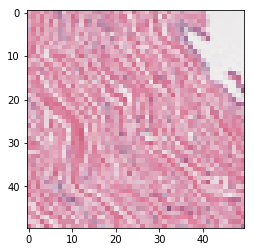

In [13]:
img = mpimg.imread(train_paths[2])
plt.imshow(img)

In [17]:
datasets = [
    ('training', train_paths, train_path),
    ('validation', val_paths, val_path),
    ('testing', test_paths, test_path)
]

In [18]:
len(datasets)

3

In [19]:
type(datasets[0])

tuple

In [20]:
len(datasets)

3

In [22]:
type(datasets)

list

In [23]:
print(datasets[0][0], datasets[0][1][0], datasets[0][2])

training datasets/orig/12870/0/12870_idx5_x151_y1601_class0.png datasets/idc/training


In [24]:
for (dtype, image_paths, base_output) in datasets:
    
    print('[info] building {} split'.format(dtype))
    
    if not os.path.exists(base_output):
        print('[info] creating {} directory'.format(base_output))
        os.makedirs(base_output)
        
    for input_path in image_paths:
        file_name = input_path.split(os.path.sep)[-1]
        label = file_name[-5:-4]
        
        label_path = os.path.sep.join([base_output, label])
        
        if not os.path.exists(label_path):
            print('[info] creating {} directory'.format(label_path))
            os.makedirs(label_path)
        
        p = os.path.sep.join([label_path, file_name])
        shutil.copy2(input_path, p)
        

[info] building training split
[info] building validation split
[info] creating datasets/idc/validation directory
[info] creating datasets/idc/validation/1 directory
[info] creating datasets/idc/validation/0 directory
[info] building testing split
[info] creating datasets/idc/testing directory
[info] creating datasets/idc/testing/0 directory
[info] creating datasets/idc/testing/1 directory


In [27]:
def baseline_model(width, height, depth, classes):
    model = Sequential()
    input_shape = (height, width, depth)
    chan_dim = -1
    
    if K.image_data_format() =='channels_first':
        input_shape = (depth, height, width)
        chan_dim = 1
    
    model.add(SeparableConv2D(32, (3, 3), padding='same',
                             input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=chan_dim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(SeparableConv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=chan_dim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(SeparableConv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=chan_dim))
    model.add(SeparableConv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=chan_dim))
    model.add(SeparableConv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=chan_dim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(classes))
    model.add(Activation('softmax'))
    
    return model

In [31]:
epochs = 40
learning_rate = 1e-2
batch_size = 32

In [32]:
print(train_path)

datasets/idc/training


In [34]:
train_paths = list(paths.list_images(train_path))
total_train = len(train_paths)
print(total_train)


199818


In [36]:
total_val = len(list(paths.list_images(val_path)))
total_test = len(list(paths.list_images(test_path)))
print(total_val)
print(total_test)

22201
55505


In [37]:
train_labels = [int(p.split(os.path.sep)[-2]) for p in train_paths]
train_labels = np_utils.to_categorical(train_labels)
class_totals = train_labels.sum(axis=0)
class_weight = class_totals.max() / class_totals

In [38]:
train_aug = ImageDataGenerator(
    rescale = 1 / 255.0,
    rotation_range=20, 
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [39]:
val_aug = ImageDataGenerator(rescale=1/255.0)

In [40]:
train_gen = train_aug.flow_from_directory(
    train_path,
    class_mode='categorical',
    target_size=(48, 48),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

val_gen = val_aug.flow_from_directory(
    val_path,
    class_mode='categorical',
    target_size=(48, 48),
    color_mode ='rgb',
    shuffle=False,
    batch_size=batch_size
)

test_gen = val_aug.flow_from_directory(
    test_path,
    class_mode='categorical',
    target_size=(48, 48),
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 199818 images belonging to 2 classes.
Found 22201 images belonging to 2 classes.
Found 55505 images belonging to 2 classes.


In [2]:
model = baseline_model(width=48, height=48, depth=3, classes=2)
model.summary()

NameError: name 'baseline_model' is not defined